In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
def remove_noise(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [4]:
def discard_colors(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [13]:
def detect_edges(image, low_threshold, high_threshold):
    return cv2.Canny(image, threshold1=low_threshold, threshold2=high_threshold)

In [6]:
def region_of_interest(image, vertices):
    # defining a blank mask to start with 
    mask = np.zeros_like(image)
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
  # returning the image only where mask pixels are non-zero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [7]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)

In [8]:
def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

In [9]:
def slope(x1, y1, x2, y2):
    return (y1 - y2) / (x1 - x2)
def separate_lines(lines):
    right = []
    left = []
    for x1,y1,x2,y2 in lines[:, 0]:
        m = slope(x1,y1,x2,y2)
        if m >= 0:
            right.append([x1,y1,x2,y2,m])
        else:
            left.append([x1,y1,x2,y2,m])
    return right, left

In [10]:
def reject_outliers(data, cutoff, threshold=0.08):
    data = np.array(data)
    data = data[(data[:, 4] >= cutoff[0]) & (data[:, 4] <= cutoff[1])]
    m = np.mean(data[:, 4], axis=0)
    return data[(data[:, 4] <= m+threshold) & (data[:, 4] >= m-threshold)]

In [24]:
def lines_linreg(lines_array):
    x = np.reshape(lines_array[:, [0, 2]], (1, len(lines_array) * 2))[0]
    y = np.reshape(lines_array[:, [1, 3]], (1, len(lines_array) * 2))[0]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    x = np.array(x)
    y = np.array(x * m + c)
    return x, y, m, c

In [25]:
def extend_point(x1, y1, x2, y2, length):
    line_len = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    x = x2 + (x2 - x1) / line_len * length
    y = y2 + (y2 - y1) / line_len * length
    return x, y

In [26]:
def weighted_image(image, initial_image, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_image, α, image, β, λ)

In [15]:
image = cv2.imread("test_lane_seperator.png")

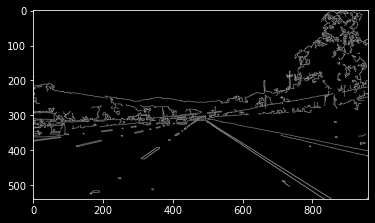

In [16]:
img = detect_edges(image, low_threshold=50, high_threshold=150)
plt.imshow(img, cmap='gray')

In [17]:
xsize = img.shape[1]
ysize = img.shape[0]
dx1 = int(0.0725 * xsize)
dx2 = int(0.425 * xsize)
dy = int(0.6 * ysize)
# calculate vertices for region of interest
vertices = np.array([[(dx1, ysize), (dx2, dy), (xsize - dx2, dy), (xsize - dx1, ysize)]], dtype=np.int32)
image = region_of_interest(img, vertices)

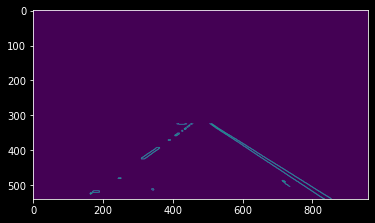

In [21]:
plt.imshow(image)

In [18]:
rho = 0.8
theta = np.pi/180
threshold = 25
min_line_len = 50
max_line_gap = 200
lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)

In [37]:
lines_reshaped = lines[:, 0, :]
lines_reshaped.shape

(161, 4)

In [45]:
right_lines, left_lines = separate_lines(lines)
right_lines

C:\Users\Phili\AppData\Local\Temp\ipykernel_26876\2399542382.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return (y1 - y2) / (x1 - x2)


[[396, 253, 854, 539, 0.6244541484716157],
 [9, 215, 874, 384, 0.19537572254335261],
 [2, 216, 543, 321, 0.19408502772643252],
 [3, 316, 531, 316, -0.0],
 [399, 254, 853, 538, 0.6255506607929515],
 [444, 284, 728, 469, 0.6514084507042254],
 [1, 312, 516, 312, -0.0],
 [393, 253, 834, 539, 0.6485260770975056],
 [238, 250, 959, 416, 0.2302357836338419],
 [224, 256, 932, 256, -0.0],
 [871, 11, 957, 415, 4.6976744186046515],
 [903, 7, 951, 400, 8.1875],
 [11, 215, 582, 326, 0.19439579684763572],
 [0, 289, 795, 289, -0.0],
 [5, 216, 959, 401, 0.19392033542976939],
 [902, 6, 958, 539, 9.517857142857142],
 [831, 84, 953, 91, 0.05737704918032787],
 [930, 13, 957, 539, 19.48148148148148],
 [591, 248, 959, 248, -0.0],
 [848, 5, 949, 357, 3.485148514851485],
 [23, 318, 540, 318, -0.0],
 [3, 325, 576, 325, -0.0],
 [914, 6, 945, 258, 8.129032258064516],
 [2, 252, 943, 252, -0.0],
 [847, 6, 872, 364, 14.32],
 [849, 5, 918, 91, 1.2463768115942029],
 [235, 250, 441, 297, 0.22815533980582525],
 [927, 8,

In [20]:
if right_lines and left_lines:
    right = reject_outliers(right_lines,  cutoff=(0.45, 0.75))
    left = reject_outliers(left_lines, cutoff=(-0.85, -0.6))

In [31]:
lines[0]

array([[396, 253, 854, 539]], dtype=int32)

In [41]:
x, y, m, c = lines_linreg(lines_reshaped)
# This variable represents the top-most point in the image where we can reasonable draw a line to.
min_y = np.min(y)
# Calculate the top point using the slopes and intercepts we got from linear regression.
top_point = np.array([(min_y - c) / m, min_y], dtype=int)
# Repeat this process to find the bottom left point.
max_y = np.max(y)
bot_point = np.array([(max_y - c) / m, max_y], dtype=int)

C:\Users\Phili\AppData\Local\Temp\ipykernel_26876\3852184540.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, y)[0]


In [42]:
x1e, y1e = extend_point(bot_point[0],bot_point[1],top_point[0],top_point[1], -1000) # bottom point
x2e, y2e = extend_point(bot_point[0],bot_point[1],top_point[0],top_point[1],  1000) # top point
# return the line.
line = np.array([[x1e,y1e,x2e,y2e]])

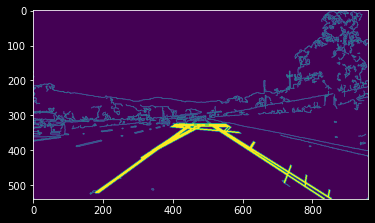

In [48]:
line_image = np.copy((image)*0)
draw_lines(line_image, lines, thickness=3)
line_image = region_of_interest(line_image, vertices)
final_image = weighted_image(line_image, img)
plt.imshow(final_image)